In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# python libraries
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, AveragePooling2D,BatchNormalization
from tensorflow.keras.utils import plot_model
from keras.utils import np_utils


from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import warnings
warnings.filterwarnings("ignore")

### **Data Generation**

In [ ]:
# data preparation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2, rotation_range= 20, zoom_range = 0.2, horizontal_flip=True)

**Preprocessing parameters:**

- rotation - 20
- zoom - 0.2
- horizontal flip 
- Data splitting - 80% (training - 1620 images), 20% (testing - 405 images)

In [ ]:
img_size = 224

In [ ]:
train_generator = datagen.flow_from_directory(
    directory="/content/drive/MyDrive/Hand Gesture/MP_Data",
    target_size=(img_size, img_size),
    shuffle=True,
    subset='training',
    batch_size=1620
)

test_generator = datagen.flow_from_directory(
    directory="/content/drive/MyDrive/Hand Gesture/MP_Data",
    target_size=(img_size, img_size),
    shuffle=True,
    subset='validation',
    batch_size=405
)

Found 1620 images belonging to 9 classes.
Found 405 images belonging to 9 classes.


In [ ]:
# gesture classes
classes = {0:'angry',
 1:'fine',
 2:'hello',
 3:'help',
 4:'none',
 5:'take_time',
 6:'thanks',
 7:'think',
 8:'tired'}

In [ ]:
# extracting train and test batches
X_train = train_generator[0][0]
y_train = train_generator[0][1]

X_test = test_generator[0][0]
y_test = test_generator[0][1]

print("Shape of training X: ", X_train.shape)
print("Shape of training y: ", y_train.shape)
print("Shape of testing X: ", X_test.shape)
print("Shape of testing y: ", y_test.shape)

Shape of training X:  (1620, 224, 224, 3)
Shape of training y:  (1620, 9)
Shape of testing X:  (405, 224, 224, 3)
Shape of testing y:  (405, 9)


#### **Training Data Distribution**

Text(0.5, 1.0, 'Distribution of classes in training data')

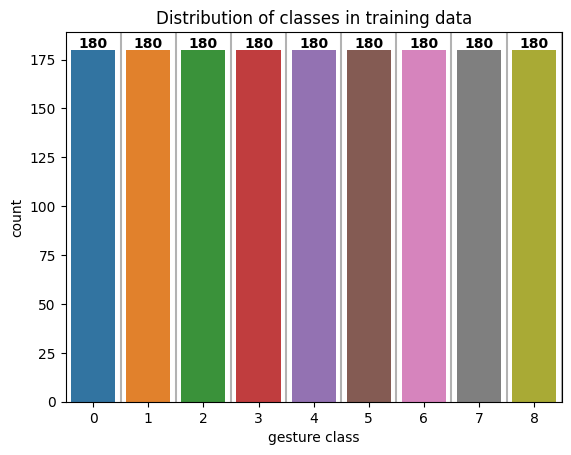

In [ ]:
# train data distribution plot
train_labels = train_generator.classes
class_counts = np.bincount(train_labels)

ax = sns.countplot(x=train_labels)
for i, count in enumerate(class_counts):
    ax.text(i, count+1, str(count), ha='center', fontsize=10, fontweight='bold')
    ax.axvline(x=i+0.5, ymin=0, ymax=1, color='black', alpha=0.3)

plt.xlabel('gesture class')
plt.title("Distribution of classes in training data")

#### **Testing Data Distribution**

Text(0.5, 1.0, 'Distribution of classes in testing data')

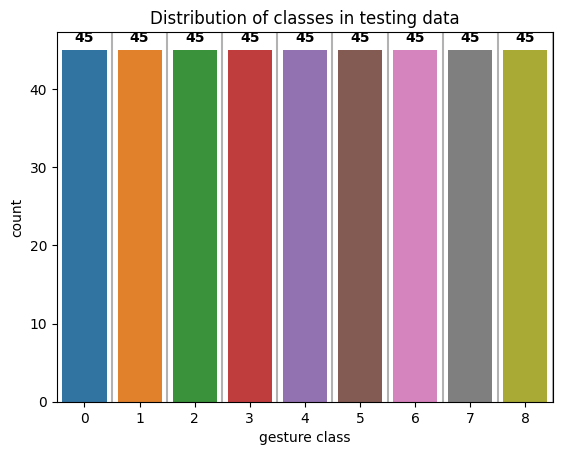

In [ ]:
# test data distribution plot
test_labels = test_generator.classes
class_counts = np.bincount(test_labels)

ax = sns.countplot(x=test_labels)
for i, count in enumerate(class_counts):
    ax.text(i, count+1, str(count), ha='center', fontsize=10, fontweight='bold')
    ax.axvline(x=i+0.5, ymin=0, ymax=1, color='black', alpha=0.3)

plt.xlabel('gesture class')
plt.title("Distribution of classes in testing data")

### **CNN**

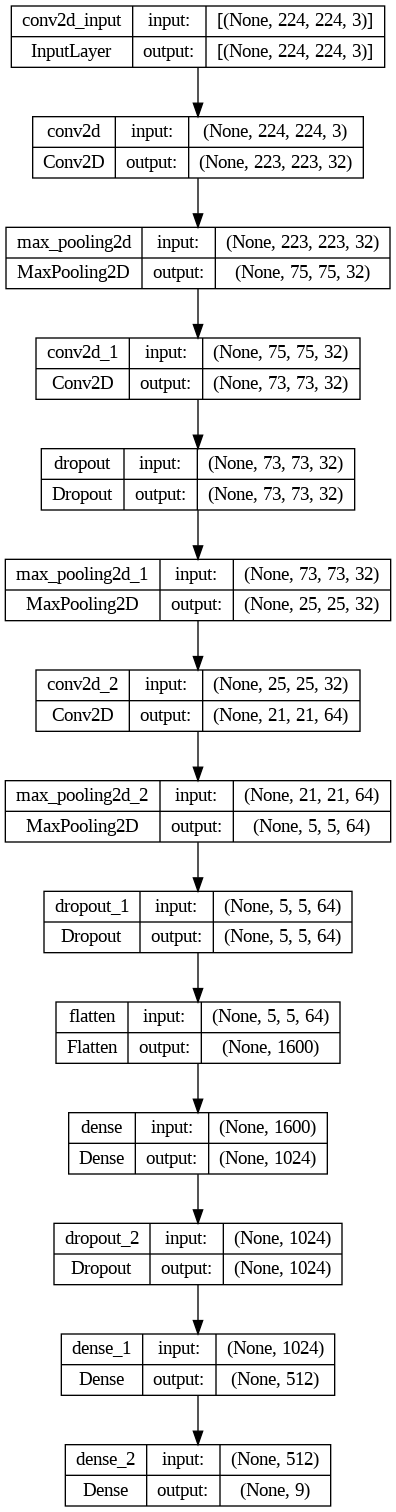

In [ ]:
#MODEL
model = Sequential()

model.add(Conv2D(32, (2,2), input_shape=(img_size, img_size, 3)))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(64, (5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(5, 5), padding='same'))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dense(9, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy', tf.keras.metrics.AUC(multi_label=True)])
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
history = model.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=20, callbacks=[early_stop])

Epoch 1/20
51/51 [==============================] - 18s 66ms/step - loss: 16.7935 - accuracy: 0.3099 - auc: 0.6677 - val_loss: 1.3958 - val_accuracy: 0.6444 - val_auc: 0.9234
Epoch 2/20
51/51 [==============================] - 2s 42ms/step - loss: 0.7827 - accuracy: 0.7247 - auc: 0.9548 - val_loss: 0.6767 - val_accuracy: 0.8395 - val_auc: 0.9817
Epoch 3/20
51/51 [==============================] - 2s 43ms/step - loss: 0.4358 - accuracy: 0.8457 - auc: 0.9837 - val_loss: 0.4708 - val_accuracy: 0.8469 - val_auc: 0.9880
Epoch 4/20
51/51 [==============================] - 2s 47ms/step - loss: 0.3365 - accuracy: 0.8815 - auc: 0.9901 - val_loss: 0.2737 - val_accuracy: 0.9086 - val_auc: 0.9964
Epoch 5/20
51/51 [==============================] - 2s 45ms/step - loss: 0.2342 - accuracy: 0.9222 - auc: 0.9939 - val_loss: 0.2744 - val_accuracy: 0.9111 - val_auc: 0.9957
Epoch 6/20
51/51 [==============================] - 2s 43ms/step - loss: 0.1746 - accuracy: 0.9426 - auc: 0.9966 - val_loss: 0.2188 -

In [ ]:
# predictions
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_true = np.argmax(y_test, axis=1)

In [ ]:
# scores
cnn_train_loss, cnn_train_acc, cnn_train_auc = model.evaluate(X_train, y_train)
cnn_test_loss, cnn_test_acc, cnn_test_auc = model.evaluate(X_test, y_test)

cnn_acc = history.history['accuracy']
cnn_val_acc = history.history['val_accuracy']
cnn_loss = history.history['loss']
cnn_val_loss = history.history['val_loss']
cnn_auc = history.history['auc']
cnn_val_auc = history.history['val_auc']

cnn_f1 = f1_score(y_true, y_pred, average='macro',)
cnn_prec = precision_score(y_true, y_pred, average='macro')
cnn_recall = recall_score(y_true, y_pred, average='macro')

In [ ]:
# storing results
performance_df = pd.DataFrame(columns=['model', 'Training accuracy', 'Training loss', 'Training AUC', 
                                       'validation accuracy', 'validation loss', 'validation AUC', 'f1 score', 'precision', 'recall'])

new_row = {'model': 'CNN', 'Training accuracy':cnn_train_acc, 'Training loss':cnn_train_loss, 'Training AUC':cnn_train_auc, 
           'validation accuracy': cnn_test_acc, 'validation loss': cnn_test_loss, 'validation AUC': cnn_test_auc,
           'f1 score':cnn_f1, 'precision':cnn_prec, 'recall':cnn_recall}
performance_df = performance_df.append(new_row, ignore_index=True)
performance_df

,model,Training accuracy,Training loss,Training AUC,validation accuracy,validation loss,validation AUC,f1 score,precision,recall
0,CNN,0.994444,0.018592,0.999982,0.94321,0.171626,0.995878,0.942686,0.946636,0.94321


In [ ]:
performance_df.to_csv('/content/drive/MyDrive/Hand Gesture/performance_df.csv', index=False)

#### **plots per epoch**

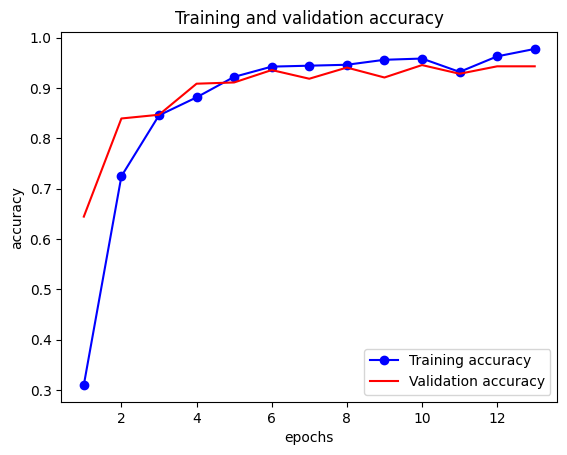

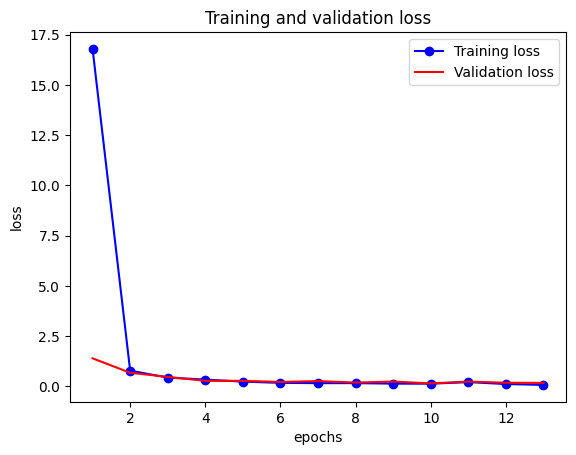

In [ ]:
# performance plots
epochs = range(1, len(cnn_acc) + 1)
plt.plot(epochs, cnn_acc, 'bo-', label='Training accuracy')
plt.plot(epochs, cnn_val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

epochs = range(1, len(cnn_loss) + 1)
plt.plot(epochs, cnn_loss, 'bo-', label='Training loss')
plt.plot(epochs, cnn_val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

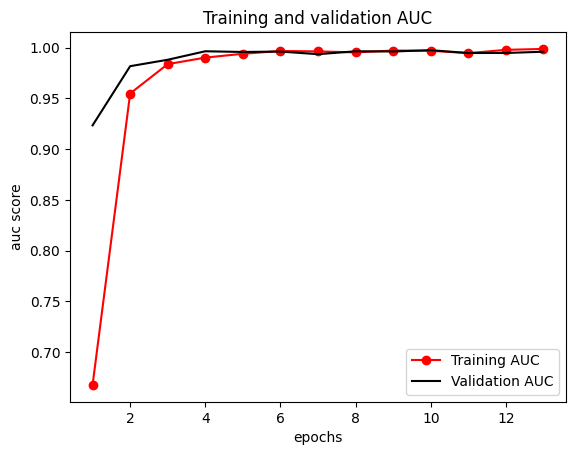

In [ ]:
# AUC
epochs = range(1, len(cnn_auc) + 1)
plt.plot(epochs, cnn_auc, 'ro-', label='Training AUC')
plt.plot(epochs, cnn_val_auc, 'black', label='Validation AUC')
plt.title('Training and validation AUC')
plt.xlabel('epochs')
plt.ylabel('auc score')
plt.legend()
plt.show()

In [ ]:
# transfer learning models 
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import EfficientNetB0, VGG16, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model

### **VGG16**

58889256/58889256 [==============================] - 3s 0us/step


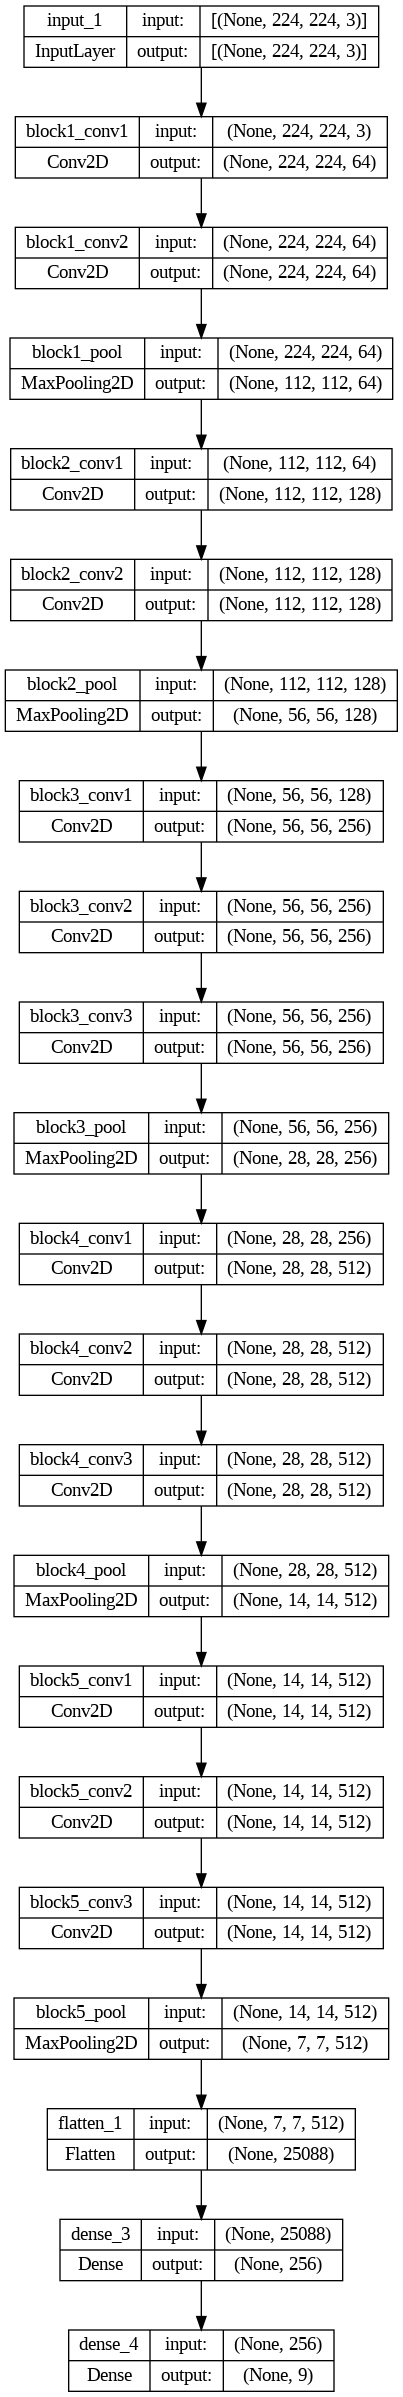

In [ ]:
# pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# freezing the base model layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(multi_label=True)])
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# training
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
history = model.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=20, callbacks=[early_stop])

Epoch 1/20
51/51 [==============================] - 19s 275ms/step - loss: 6.5645 - accuracy: 0.8623 - auc_1: 0.9298 - val_loss: 7.3790 - val_accuracy: 0.8642 - val_auc_1: 0.9281
Epoch 2/20
51/51 [==============================] - 9s 175ms/step - loss: 0.7583 - accuracy: 0.9809 - auc_1: 0.9903 - val_loss: 2.4566 - val_accuracy: 0.9481 - val_auc_1: 0.9751
Epoch 3/20
51/51 [==============================] - 8s 158ms/step - loss: 0.9804 - accuracy: 0.9846 - auc_1: 0.9928 - val_loss: 4.2572 - val_accuracy: 0.9432 - val_auc_1: 0.9722
Epoch 4/20
51/51 [==============================] - 8s 156ms/step - loss: 0.6796 - accuracy: 0.9809 - auc_1: 0.9916 - val_loss: 3.2632 - val_accuracy: 0.9580 - val_auc_1: 0.9764
Epoch 5/20
51/51 [==============================] - 9s 179ms/step - loss: 0.1326 - accuracy: 0.9938 - auc_1: 0.9972 - val_loss: 4.3858 - val_accuracy: 0.9556 - val_auc_1: 0.9751
Epoch 5: early stopping


In [ ]:
# prediction
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

13/13 [==============================] - 2s 117ms/step


In [ ]:
# scores
vgg_train_loss, vgg_train_acc, vgg_train_auc = model.evaluate(X_train, y_train)
vgg_test_loss, vgg_test_acc, vgg_test_auc = model.evaluate(X_test, y_test)

vgg_acc = history.history['accuracy']
vgg_val_acc = history.history['val_accuracy']
vgg_loss = history.history['loss']
vgg_val_loss = history.history['val_loss']
vgg_auc = history.history['auc_1']
vgg_val_auc = history.history['val_auc_1']


vgg_f1 = f1_score(y_true, y_pred, average='macro')
vgg_prec = precision_score(y_true, y_pred, average='macro')
vgg_recall = recall_score(y_true, y_pred, average='macro')

In [ ]:
# storing results
new_row = {'model': 'VGG16', 'Training accuracy':vgg_train_acc, 'Training loss':vgg_train_loss, 'Training AUC':vgg_train_auc, 
           'validation accuracy': vgg_test_acc, 'validation loss': vgg_test_loss, 'validation AUC': vgg_test_auc,
           'f1 score':vgg_f1, 'precision':vgg_prec, 'recall':vgg_recall}

performance_df = performance_df.append(new_row, ignore_index=True)
performance_df

,model,Training accuracy,Training loss,Training AUC,validation accuracy,validation loss,validation AUC,f1 score,precision,recall
0,CNN,0.994444,0.018592,0.999982,0.943210,0.171626,0.995878,0.942686,0.946636,0.943210
1,VGG16,0.999383,0.009540,0.999653,0.955556,4.385849,0.975144,0.954046,0.957865,0.955556


In [ ]:
performance_df.to_csv('/content/drive/MyDrive/Hand Gesture/performance_df.csv', index=False)

#### **plots per epoch**

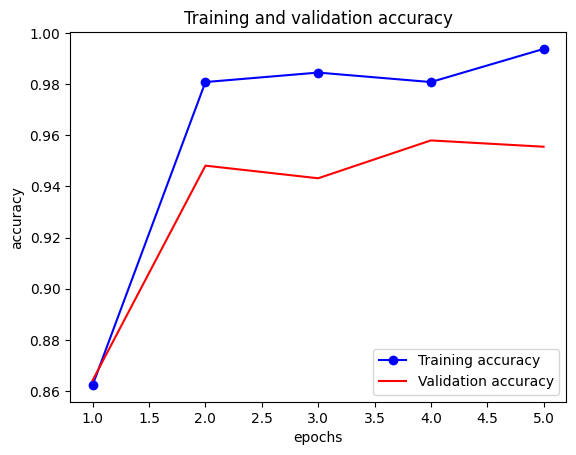

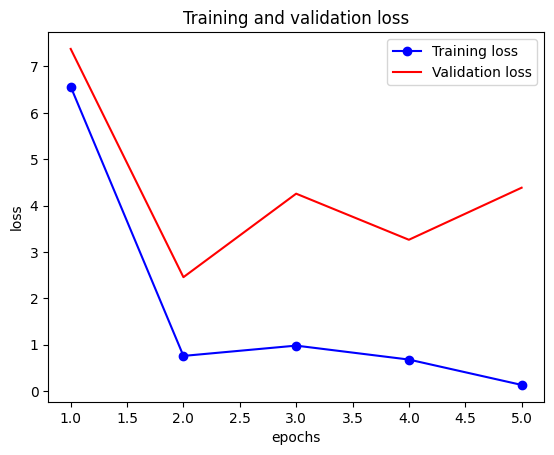

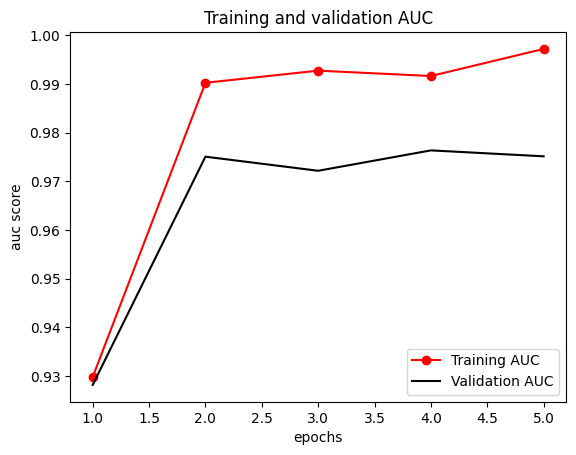

In [ ]:
# performance plots
epochs = range(1, len(vgg_acc) + 1)
plt.plot(epochs, vgg_acc, 'bo-', label='Training accuracy')
plt.plot(epochs, vgg_val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

epochs = range(1, len(vgg_loss) + 1)
plt.plot(epochs, vgg_loss, 'bo-', label='Training loss')
plt.plot(epochs, vgg_val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# AUC
epochs = range(1, len(vgg_auc) + 1)
plt.plot(epochs, vgg_auc, 'ro-', label='Training AUC')
plt.plot(epochs, vgg_val_auc, 'black', label='Validation AUC')
plt.title('Training and validation AUC')
plt.xlabel('epochs')
plt.ylabel('auc score')
plt.legend()
plt.show()

### **EfficientNetB0**

In [ ]:
# pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(multi_label=True)])
plot_model(model, show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# training
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
history = model.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=20, callbacks=[early_stop])

Epoch 1/20
51/51 [==============================] - 16s 154ms/step - loss: 0.4321 - accuracy: 0.8852 - auc_2: 0.9899 - val_loss: 0.2472 - val_accuracy: 0.9333 - val_auc_2: 0.9949
Epoch 2/20
51/51 [==============================] - 5s 93ms/step - loss: 0.0424 - accuracy: 0.9951 - auc_2: 0.9999 - val_loss: 0.1559 - val_accuracy: 0.9580 - val_auc_2: 0.9964
Epoch 3/20
51/51 [==============================] - 4s 86ms/step - loss: 0.0278 - accuracy: 0.9975 - auc_2: 0.9999 - val_loss: 0.1585 - val_accuracy: 0.9654 - val_auc_2: 0.9968
Epoch 4/20
51/51 [==============================] - 4s 89ms/step - loss: 0.0155 - accuracy: 0.9975 - auc_2: 1.0000 - val_loss: 0.2718 - val_accuracy: 0.9235 - val_auc_2: 0.9928
Epoch 5/20
51/51 [==============================] - 5s 99ms/step - loss: 0.0138 - accuracy: 0.9994 - auc_2: 1.0000 - val_loss: 0.1246 - val_accuracy: 0.9679 - val_auc_2: 0.9970
Epoch 6/20
51/51 [==============================] - 4s 86ms/step - loss: 0.0126 - accuracy: 0.9969 - auc_2: 1.000

In [ ]:
# prediction
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

13/13 [==============================] - 2s 60ms/step


In [ ]:
# estimating scores
eff_train_loss, eff_train_acc, eff_train_auc  = model.evaluate(X_test, y_test)
eff_test_loss, eff_test_acc, eff_test_auc = model.evaluate(X_test, y_test)

eff_acc = history.history['accuracy']
eff_val_acc = history.history['val_accuracy']
eff_loss = history.history['loss']
eff_val_loss = history.history['val_loss']
eff_auc = history.history['auc_2']
eff_val_auc = history.history['val_auc_2']


eff_f1 = f1_score(y_true, y_pred, average='macro')
eff_prec = precision_score(y_true, y_pred, average='macro')
eff_recall = recall_score(y_true, y_pred, average='macro')

13/13 [==============================] - 1s 61ms/step - loss: 0.1691 - accuracy: 0.9506 - auc_2: 0.9971


In [ ]:
new_row = {'model': 'EfficientNetB0', 'Training accuracy':eff_train_acc, 'Training loss':eff_train_loss, 'Training AUC':eff_train_auc, 
           'validation accuracy': eff_test_acc, 'validation loss': eff_test_loss, 'validation AUC': eff_test_auc,
            'f1 score':eff_f1, 'precision':eff_prec, 'recall':eff_recall}

performance_df = performance_df.append(new_row, ignore_index=True)
performance_df

,model,Training accuracy,Training loss,Training AUC,validation accuracy,validation loss,validation AUC,f1 score,precision,recall
0,CNN,0.994444,0.018592,0.999982,0.943210,0.171626,0.995878,0.942686,0.946636,0.943210
1,VGG16,0.999383,0.009540,0.999653,0.955556,4.385849,0.975144,0.954046,0.957865,0.955556
2,EfficientNetB0,0.950617,0.169118,0.997088,0.950617,0.169118,0.997088,0.949197,0.957218,0.950617


In [ ]:
performance_df.to_csv('/content/drive/MyDrive/Hand Gesture/performance_df.csv', index=False)

#### **plots per epoch**

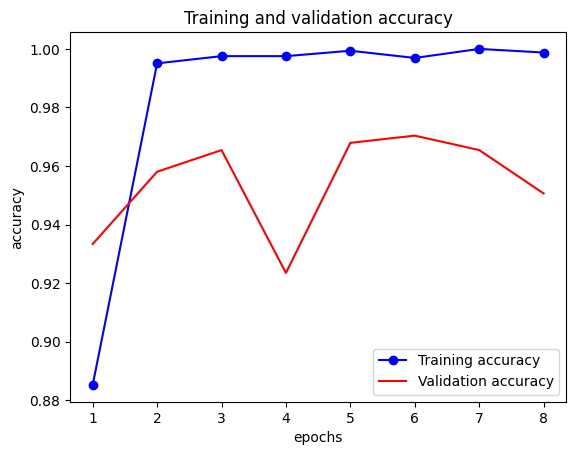

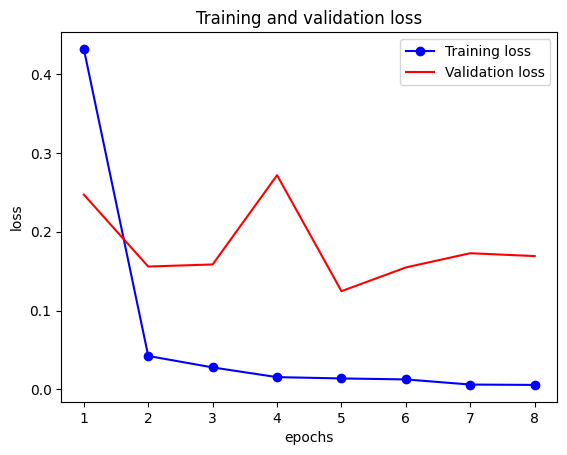

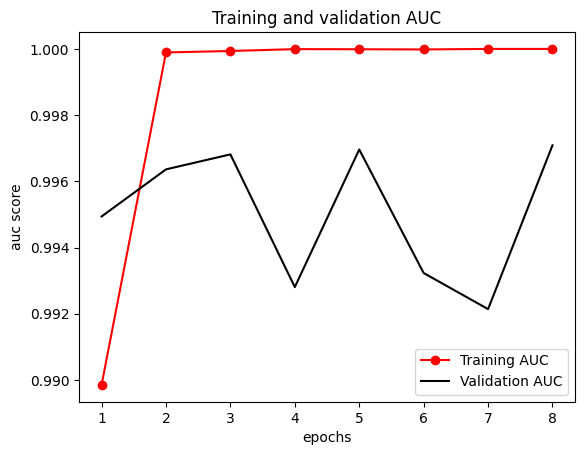

In [ ]:
# performance plots
epochs = range(1, len(eff_acc) + 1)
plt.plot(epochs, eff_acc, 'bo-', label='Training accuracy')
plt.plot(epochs, eff_val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

epochs = range(1, len(eff_loss) + 1)
plt.plot(epochs, eff_loss, 'bo-', label='Training loss')
plt.plot(epochs, eff_val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

epochs = range(1, len(eff_auc) + 1)
plt.plot(epochs, eff_auc, 'ro-', label='Training AUC')
plt.plot(epochs, eff_val_auc, 'black', label='Validation AUC')
plt.title('Training and validation AUC')
plt.xlabel('epochs')
plt.ylabel('auc score')
plt.legend()
plt.show()

### **MobileNetV2**

9406464/9406464 [==============================] - 1s 0us/step


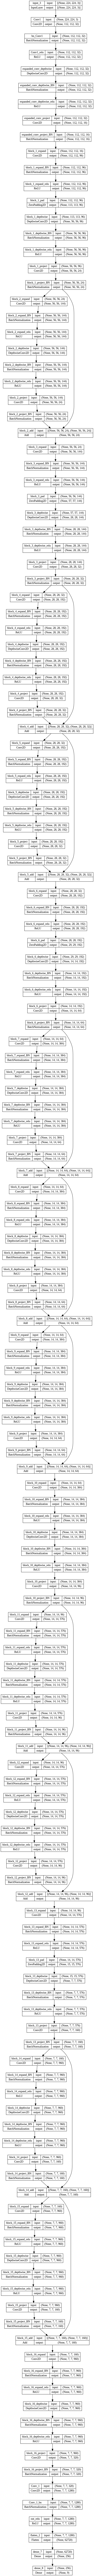

In [ ]:
# pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(multi_label=True)])
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# training
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
history = model.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=20, callbacks=[early_stop])

Epoch 1/20
51/51 [==============================] - 12s 151ms/step - loss: 4.7017 - accuracy: 0.8222 - auc_3: 0.9267 - val_loss: 2.2761 - val_accuracy: 0.9136 - val_auc_3: 0.9639
Epoch 2/20
51/51 [==============================] - 3s 68ms/step - loss: 0.1960 - accuracy: 0.9827 - auc_3: 0.9944 - val_loss: 0.8830 - val_accuracy: 0.9506 - val_auc_3: 0.9791
Epoch 3/20
51/51 [==============================] - 3s 64ms/step - loss: 0.0752 - accuracy: 0.9901 - auc_3: 0.9972 - val_loss: 1.4750 - val_accuracy: 0.9432 - val_auc_3: 0.9694
Epoch 4/20
51/51 [==============================] - 3s 66ms/step - loss: 0.0278 - accuracy: 0.9951 - auc_3: 0.9989 - val_loss: 0.6175 - val_accuracy: 0.9605 - val_auc_3: 0.9831
Epoch 5/20
51/51 [==============================] - 3s 68ms/step - loss: 0.0276 - accuracy: 0.9944 - auc_3: 0.9990 - val_loss: 1.4456 - val_accuracy: 0.9457 - val_auc_3: 0.9713
Epoch 6/20
51/51 [==============================] - 4s 70ms/step - loss: 0.1757 - accuracy: 0.9877 - auc_3: 0.995

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

13/13 [==============================] - 1s 43ms/step


In [ ]:
mob_train_loss, mob_train_acc, mob_train_auc = model.evaluate(X_test, y_test)
mob_test_loss, mob_test_acc, mob_test_auc = model.evaluate(X_test, y_test)

mob_acc = history.history['accuracy']
mob_val_acc = history.history['val_accuracy']
mob_loss = history.history['loss']
mob_val_loss = history.history['val_loss']
mob_auc = history.history['auc_3']
mob_val_auc = history.history['val_auc_3']


mob_f1 = f1_score(y_true, y_pred, average="macro")
mob_prec = precision_score(y_true, y_pred, average="macro")
mob_recall = recall_score(y_true, y_pred, average="macro")

13/13 [==============================] - 1s 42ms/step - loss: 1.1946 - accuracy: 0.9457 - auc_3: 0.9751


In [ ]:
new_row = {'model': 'MobileNetV2', 'Training accuracy':mob_train_acc, 'Training loss':mob_train_loss, 'Training AUC':mob_train_auc, 
           'validation accuracy': mob_test_acc, 'validation loss': mob_test_loss, 'validation AUC': mob_test_auc,
            'f1 score':mob_f1, 'precision':mob_prec, 'recall':mob_recall}

performance_df = performance_df.append(new_row, ignore_index=True)
performance_df

,model,Training accuracy,Training loss,Training AUC,validation accuracy,validation loss,validation AUC,f1 score,precision,recall
0,CNN,0.994444,0.018592,0.999982,0.943210,0.171626,0.995878,0.942686,0.946636,0.943210
1,VGG16,0.999383,0.009540,0.999653,0.955556,4.385849,0.975144,0.954046,0.957865,0.955556
2,EfficientNetB0,0.950617,0.169118,0.997088,0.950617,0.169118,0.997088,0.949197,0.957218,0.950617
3,MobileNetV2,0.945679,1.194619,0.975110,0.945679,1.194619,0.975110,0.944947,0.948913,0.945679


In [ ]:
performance_df.to_csv('/content/drive/MyDrive/Hand Gesture/performance_df.csv', index=False)

#### **plots per epoch**

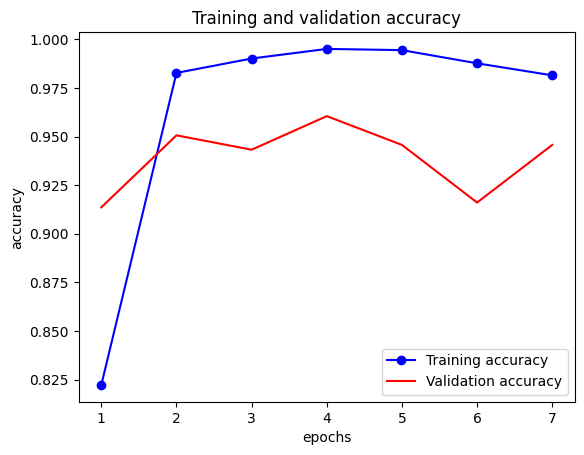

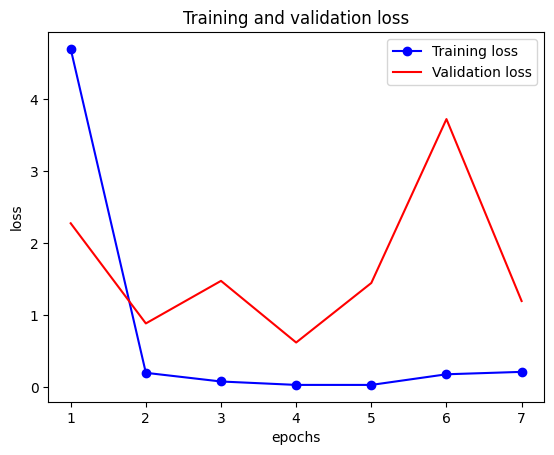

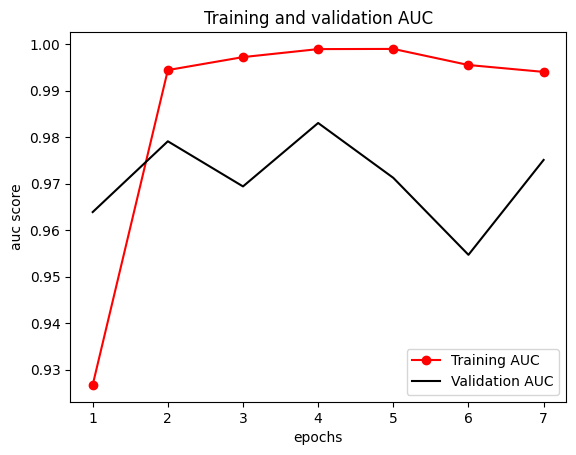

In [ ]:
# performance plots
epochs = range(1, len(mob_acc) + 1)
plt.plot(epochs, mob_acc, 'bo-', label='Training accuracy')
plt.plot(epochs, mob_val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

epochs = range(1, len(mob_loss) + 1)
plt.plot(epochs, mob_loss, 'bo-', label='Training loss')
plt.plot(epochs, mob_val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

epochs = range(1, len(mob_auc) + 1)
plt.plot(epochs, mob_auc, 'ro-', label='Training AUC')
plt.plot(epochs, mob_val_auc, 'black', label='Validation AUC')
plt.title('Training and validation AUC')
plt.xlabel('epochs')
plt.ylabel('auc score')
plt.legend()
plt.show()

### **Prediction**

1/1 [==============================] - 0s 30ms/step
Actual: fine
Prediction:  fine


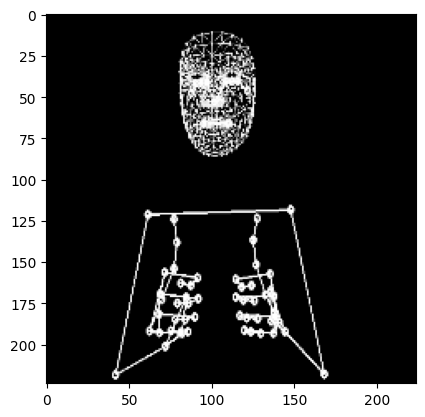

In [ ]:
image = cv2.imread("/content/drive/MyDrive/Hand Gesture/testing data/fine.png")

image = cv2.resize(image,(img_size,img_size))
plt.imshow(image)
image = image.reshape(1,img_size,img_size,3)

prediction = model.predict(image)
print("Actual: fine")
print("Prediction: ", classes[np.argmax(prediction)])

1/1 [==============================] - 0s 24ms/step
Actual: take time
Prediction:  take_time


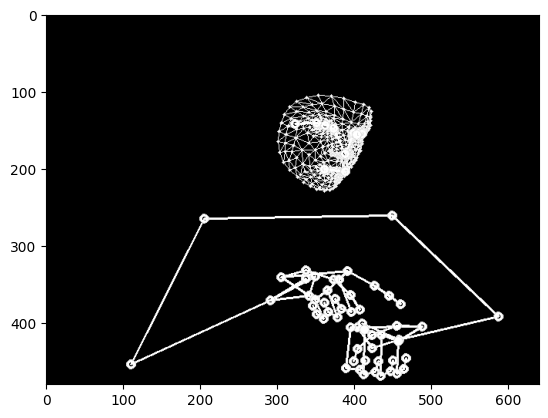

In [ ]:

###########
image = cv2.imread("/content/drive/MyDrive/Hand Gesture/testing data/take_time.png")
plt.imshow(image)

image = cv2.resize(image,(img_size,img_size))
image = image.reshape(1,img_size,img_size,3)

prediction = model.predict(image)
print("Actual: take time")
print("Prediction: ", classes[np.argmax(prediction)])

### **Word Tuner: Sentence Suggestion**


Below are the sample sentence formation and recommendation from the group od words predicted by the outperformed model.

In [ ]:
!pip install git+https://github.com/PrithivirajDamodaran/Parrot.git

from parrot import Parrot
import torch

In [ ]:
from parrot import Parrot
import torch
import warnings
warnings.filterwarnings("ignore")

def random_state(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

random_state(1234)

parrot = Parrot(model_tag="prithivida/parrot_paraphraser_on_T5", use_gpu=False)

phrases = ["fine take time "]

for phrase in phrases:
  print("-"*100)
  print("Input_phrase: ", phrase)
  print("-"*100)
  para_phrases = parrot.augment(input_phrase=phrase)
  for para_phrase in para_phrases:
   print(para_phrase)


phrases = ["hello thanks help "]

for phrase in phrases:
  print("-"*100)
  print("Input_phrase: ", phrase)
  print("-"*100)
  para_phrases = parrot.augment(input_phrase=phrase)
  for para_phrase in para_phrases:
   print(para_phrase)

----------------------------------------------------------------------------------------------------
Input_phrase:  fine take time 
----------------------------------------------------------------------------------------------------
('please take time', 13)
----------------------------------------------------------------------------------------------------
Input_phrase:  hello thanks help 
----------------------------------------------------------------------------------------------------
('hello thank you for helping', 23)
('hello thanks for helping', 19)


## **RESULTS**


In [ ]:
performance_df = pd.read_csv('/content/drive/MyDrive/Hand Gesture/performance_df.csv')
performance_df.style.background_gradient(cmap='Blues')

,model,Training accuracy,Training loss,Training AUC,validation accuracy,validation loss,validation AUC,f1 score,precision,recall
0,CNN,0.994444,0.018592,0.999982,0.943210,0.171626,0.995878,0.942686,0.946636,0.943210
1,VGG16,0.999383,0.009540,0.999653,0.955556,4.385849,0.975144,0.954046,0.957865,0.955556
2,EfficientNetB0,0.950617,0.169118,0.997088,0.950617,0.169118,0.997088,0.949197,0.957218,0.950617
3,MobileNetV2,0.945679,1.194619,0.975110,0.945679,1.194619,0.975110,0.944947,0.948913,0.945679


#### **Accuracy**

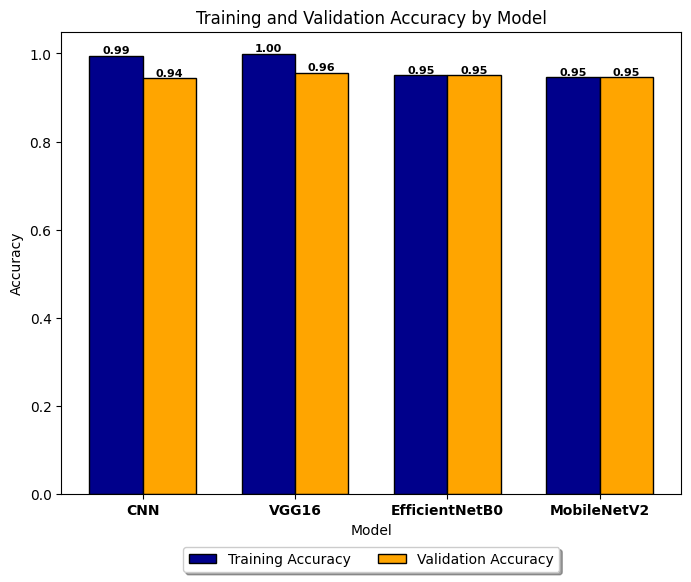

In [ ]:
models = performance_df['model']
train_acc = performance_df['Training accuracy']
val_acc = performance_df['validation accuracy']

fig, ax = plt.subplots(figsize=(8, 6))
index = np.arange(len(models))
bar_width = 0.35

# Plot bars
train_bars = ax.bar(index, train_acc, bar_width, color='darkblue', edgecolor='black', linewidth=1, label='Training Accuracy')
val_bars = ax.bar(index + bar_width, val_acc, bar_width, color='orange', edgecolor='black', linewidth=1, label='Validation Accuracy')

# Add labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy by Model')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models, fontweight='bold')

# Add text to bars
for i, v in enumerate(train_acc):
    ax.text(i, v + 0.005, '{:.2f}'.format(v), ha='center', fontsize=8, fontweight='bold')
    
for i, v in enumerate(val_acc):
    ax.text(i + bar_width, v + 0.005, '{:.2f}'.format(v), ha='center', fontsize=8, fontweight='bold')

# Add legend outside the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)

# Show plot
plt.show()

#### **Loss**

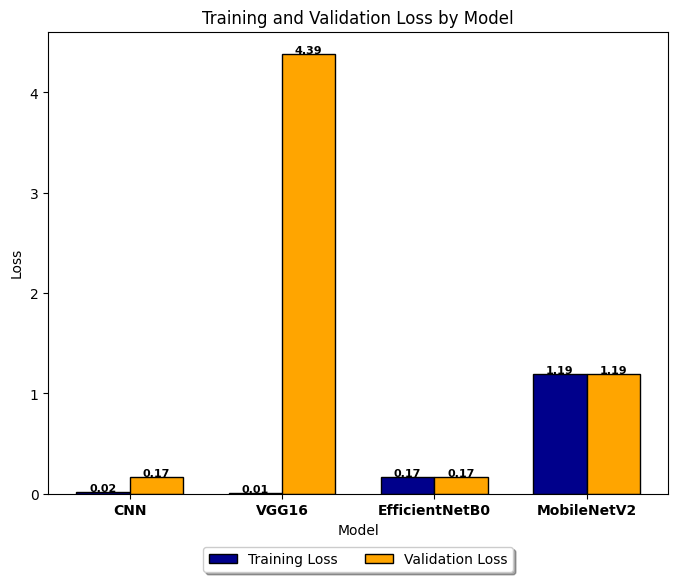

In [ ]:
train_loss = performance_df['Training loss']
val_loss = performance_df['validation loss']

fig, ax = plt.subplots(figsize=(8, 6))
index = np.arange(len(models))
bar_width = 0.35

# Plot bars
train_bars = ax.bar(index, train_loss, bar_width, color='darkblue', edgecolor='black', linewidth=1, label='Training Loss')
val_bars = ax.bar(index + bar_width, val_loss, bar_width, color='orange', edgecolor='black', linewidth=1, label='Validation Loss')

# Add labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss by Model')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models, fontweight='bold')

# Add text to bars
for i, v in enumerate(train_loss):
    ax.text(i, v + 0.005, '{:.2f}'.format(v), ha='center', fontsize=8, fontweight='bold')
    
for i, v in enumerate(val_loss):
    ax.text(i + bar_width, v + 0.005, '{:.2f}'.format(v), ha='center', fontsize=8, fontweight='bold')

# Add legend outside the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)

# Show plot
plt.show()

#### **AUC Score**

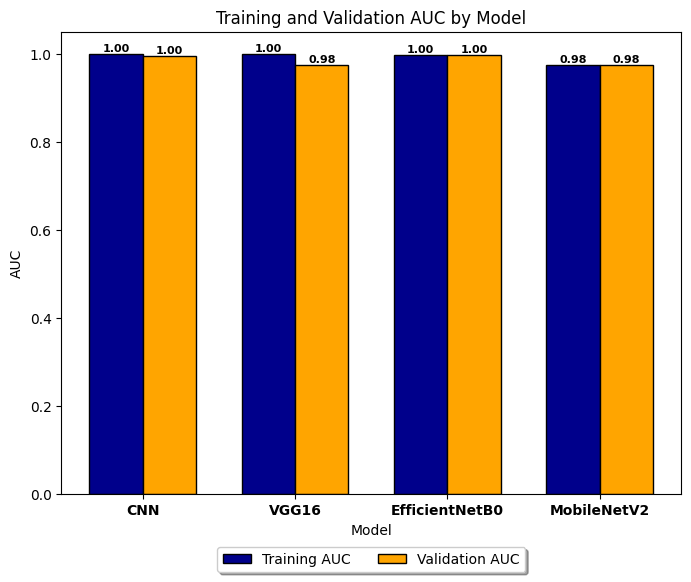

In [ ]:
train_auc = performance_df['Training AUC']
val_auc = performance_df['validation AUC']

fig, ax = plt.subplots(figsize=(8, 6))
index = np.arange(len(models))
bar_width = 0.35

# Plot bars
train_bars = ax.bar(index, train_auc, bar_width, color='darkblue', edgecolor='black', linewidth=1, label='Training AUC')
val_bars = ax.bar(index + bar_width, val_auc, bar_width, color='orange', edgecolor='black', linewidth=1, label='Validation AUC')

# Add labels and title
ax.set_xlabel('Model')
ax.set_ylabel('AUC')
ax.set_title('Training and Validation AUC by Model')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models, fontweight='bold')

# Add text to bars
for i, v in enumerate(train_auc):
    ax.text(i, v + 0.005, '{:.2f}'.format(v), ha='center', fontsize=8, fontweight='bold')
    
for i, v in enumerate(val_auc):
    ax.text(i + bar_width, v + 0.005, '{:.2f}'.format(v), ha='center', fontsize=8, fontweight='bold')

# Add legend outside the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)

# Show plot
plt.show()

#### **F1, Precision, Recall**

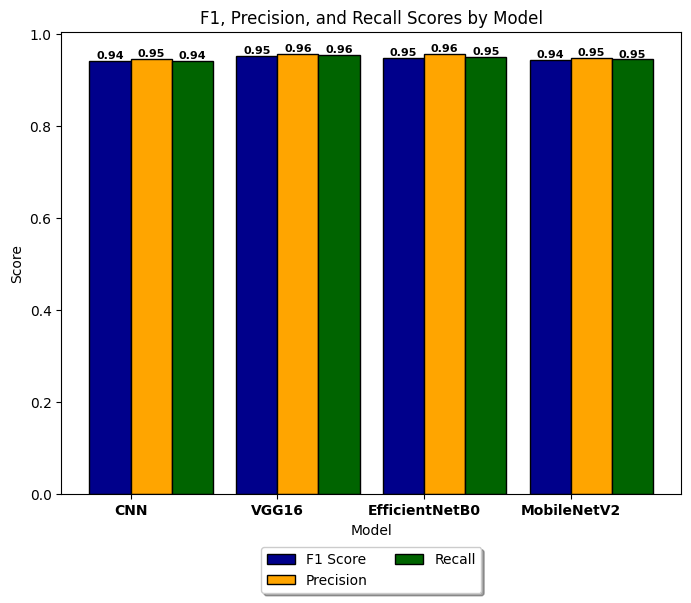

In [ ]:
f1 = performance_df['f1 score']
prec = performance_df['precision']
rec = performance_df['recall']

fig, ax = plt.subplots(figsize=(8, 6))
index = np.arange(len(models))
bar_width = 0.28

# Plot bars
f1_bars = ax.bar(index, f1, bar_width, color='darkblue', edgecolor='black', linewidth=1, label='F1 Score')
prec_bars = ax.bar(index + bar_width, prec, bar_width, color='orange', edgecolor='black', linewidth=1, label='Precision')
rec_bars = ax.bar(index + bar_width + bar_width, rec, bar_width, color='darkgreen', edgecolor='black', linewidth=1, label='Recall')

# Add labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('F1, Precision, and Recall Scores by Model')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models, fontweight='bold')

# Add text to bars
for i, v in enumerate(f1):
    ax.text(i, v + 0.005, '{:.2f}'.format(v), ha='center', fontsize=8, fontweight='bold')
    
for i, v in enumerate(prec):
    ax.text(i + bar_width, v + 0.005, '{:.2f}'.format(v), ha='center', fontsize=8, fontweight='bold')

for i, v in enumerate(rec):
    ax.text(i + bar_width + bar_width, v + 0.005, '{:.2f}'.format(v), ha='center', fontsize=8, fontweight='bold')

# Add legend outside the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)

# Show plot
plt.show()